<a id="top"></a>
# Calculating the Hubble Constant with eBOSS 
***
## Learning Goals


By the end of this tutorial, you will:

- Understand how to use `astroquery.mast` to download SDSS eBOSS and HST data from the MAST archive.
- Plot a sample of galaxies from eBOSS with a line of best fit to determine Hubble's constant.
- Create a color image of Abell 2199 from HST data.

## Table of Contents 
* [Introduction](#introduction)
* [Imports](#imports)
* [Accessing eBOSS Data from MAST](#accessing-eboss-data-from-mast)
    * [Querying eBOSS Data](#querying-eboss-data)
    * [Sampling eBOSS for Redshifted Galaxies](#sampling-eboss-for-redshifted-galaxies)
    * [Downloading Products from eBOSS](#downloading-products-from-eboss)
    * [Making the Hubble-Lemaître Diagram](#making-the-hubble-lemaître-diagram)
    * [Plotting eBOSS Data](#plotting-eboss-data)
      * [Importing Abell 2199 Data](#importing-abell-2199-data)
    * [Comparing Calculated H<sub>0</sub> to Other Models](#comparing-calculated-h0-to-other-models)
* [Utilizing HST Data from Mast](#utilizing-hst-data-from-mast)
    * [Creating an Image of Abell 2199 Using HST](#creating-an-image-of-abell-2199-using-hst)
    * [Plotting the HST Images](#plotting-the-hst-images)
    * [Colorizing the HST Image](#colorizing-the-hst-image-of-abell-2199)
* [End of Tutorial](#end-of-tutorial)
* [Additional Resources](#additional-resources)
* [Citations](#citations)
* [About this Notebook](#about-this-notebook)




## Introduction 
The Hubble-Lemaître law is one of the most prominent topics of debate in modern cosmology. In 1927, Georges Lemaître published a paper in a Belgian journal proposing that the Universe was expanding, using data from Vesto Slipher at Lowell Observatory. Around the same time, Edwin Hubble was independently studying the relationship between galaxy distances and their radial velocities at Mount Wilson Observatory. Although Hubble was originally credited with the discovery, in 2018 the International Astronomical Union officially renamed "Hubble’s Law" to the "Hubble–Lemaître Law" to acknowledge Lemaître’s earlier contribution  [[1]](https://pressbooks.bccampus.ca/astronomy1105/chapter/26-5-the-expanding-universe/).

The Big Bang occurred approximately 14 billion years ago, leading to the expansion of the Universe. We can estimate the speed of this expansion by examining the redshifts of a sample of galaxies. These redshifts can be translated into radial velocities, and then using observed spectral flux, we can the determine the distances to these galaxies. By plotting radial velocities versus distances, we can apply a linear fit model to the data. This allows us to approximate the Hubble constant from the slope as described by Hubble's Law [[2]](https://www.teachastronomy.com/textbook/The-Expanding-Universe/Relating-Redshift-and-Distance/):

$$
v_{rad} = H_{0}d
$$

There are various models used to calculate H<sub>0</sub>, some based on observations of the Cosmic Microwave Background (CMB), and others on measurements of galaxies or supernovae. These models typically yield varying values of H<sub>0</sub> ranging from approximately 67 km/s/Mpc to 74 km/s/Mpc. This discrepancy is known as the *Hubble Tension* [[3]](https://doi.org/10.3390/universe9020094). 

In this notebook, we'll construct a Hubble-Lemaître Diagram using data from the Sloan Digital Sky Survey’s (SDSS) Extended Baryon Oscillation Spectroscopic Survey (eBOSS). eBOSS gathered over 4 million spectra from stars, quasars, and galaxies. We'll focus on a subset of galaxies, using their redshifts and spectral data to plot radial velocity against distance. By applying a linear fit to this relationship, we can estimate Hubble's constant from the slope of the resulting line.

## Imports 
The main packages and their use-cases in this tutorial are as follows:

- *numpy* to handle array functions
- *matplotlib.pyplot* for plotting data 
- *astroquery.mast.Observations* to access data from MAST
- *astropy.io.fits* for accessing FITS files
- *astropy.table.vstack* for vertically stacking tables
- *scipy.optimize.curve_fit* for creating a linear fit 
- *astropy.visualization.make_luptopn_rgb* for creating an RGB image 
- *astropy.wcs.WCS* for world coordinate system transformations
- *reproject* for stacking FITS images

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from astroquery.mast import Observations
import astropy.io.fits as fits
from astropy.table import vstack
from scipy.optimize import curve_fit

from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
import reproject

If you're not sure if you have the required versions of packages installed on your device, you can run the following cell:

In [2]:
with open("requirements.txt") as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy >= 5.3
astroquery >= 0.4.9
matplotlib >= 3.9.1
numpy >= 1.26.4
scipy >= 1.15.3
reproject >= 0.14.0


To ensure these requirements are installed, you can run the following command in the terminal:
```bash
pip install -r requirements.txt
```

***

## Accessing eBOSS Data from MAST 

The [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) hosts a large array of data from several telescope missions. In this tutorial, we will be specifically focusing on data from the Sloan Digital Sky Survey (SDSS) and the Hubble Space Telescope (HST). 

The [Extended Baryon Oscillation Spectroscopic Survey (eBOSS)](https://www.sdss4.org/surveys/eboss/) was completed using the SDSS-2.5m telescope and BOSS spectrograph at the Apache Point Observatory in New Mexico. Using plug plates and a 1000 fiber-fed spectrograph, eBOSS was able to collect spectra from over 4 million objects including quasars, galaxies, and stars in the northern hemisphere.

### Querying eBOSS Data 

You can query data from MAST using the [website portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html). You can also query MAST data in Python using the package `astroquery.mast`! 

We can query all of the eBOSS data using `Observations.query_criteria` with `provenance_name = 'eBOSS'` and `obs_collection = 'SDSS'`. Since eBOSS has a large amount of data, we can display the first 10 results using the `pagesize` parameter as well as the `page` parameter. 

We can also limit the number of observations by date. Using the `t_min=[58118, 60675]` parameter (the modified Julian date of the exposure), we can filter data that has a modified Julian date from 58118 to 60676 (years 2018-2024). 

This might take a few minutes depending on your internet connection.

In [3]:
eboss_data = Observations.query_criteria(
    obs_collection="SDSS",
    provenance_name="eBOSS",
    t_min=[58118, 60675],
    pagesize=5,
    page=1,
)

# Show the astropy table
eboss_data

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str4,str4,str4,str7,str21,str6,str27,float64,float64,str8,str18,int64,float64,float64,float64,float64,float64,str56,float64,str3,str1,int64,str56,str64,str64,str6,bool,float64,str9,str9
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 10759-58526-429,GALAXY,sdss_eboss_10759-58526-0429,210.4510299999999,38.233801,spectrum,SDSS Collaboration,3,58523.37033564815,58526.410765162036,3600.41,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 210.4510299999999 38.233801 0.0002777777777777778,mast:SDSS/eboss/10759/58526/0429/spec-image-10759-58526-0429.png,mast:SDSS/eboss/10759/58526/0429/full/spec-10759-58526-0429.fits,PUBLIC,False,nan,243450949,723271914
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 10759-58526-904,QSO,sdss_eboss_10759-58526-0904,211.82028,39.947863,spectrum,SDSS Collaboration,3,58523.37033564815,58526.410766203706,3600.41,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 211.82028 39.947863 0.0002777777777777778,mast:SDSS/eboss/10759/58526/0904/spec-image-10759-58526-0904.png,mast:SDSS/eboss/10759/58526/0904/full/spec-10759-58526-0904.fits,PUBLIC,False,nan,243450984,723271967
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 10759-58526-921,QSO,sdss_eboss_10759-58526-0921,211.96721,39.285269,spectrum,SDSS Collaboration,3,58523.37033564815,58526.410766203706,3600.41,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 211.96721 39.285269 0.0002777777777777778,mast:SDSS/eboss/10759/58526/0921/spec-image-10759-58526-0921.png,mast:SDSS/eboss/10759/58526/0921/full/spec-10759-58526-0921.fits,PUBLIC,False,nan,243451002,723272001
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 10759-58526-739,QSO,sdss_eboss_10759-58526-0739,210.9883,38.71173,spectrum,SDSS Collaboration,3,58523.37033564815,58526.410766203706,3600.41,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 210.9883 38.71173 0.0002777777777777778,mast:SDSS/eboss/10759/58526/0739/spec-image-10759-58526-0739.png,mast:SDSS/eboss/10759/58526/0739/full/spec-10759-58526-0739.fits,PUBLIC,False,nan,243451049,723272072
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 10759-58526-33,QSO,sdss_eboss_10759-58526-0033,212.46253,38.435741,spectrum,SDSS Collaboration,3,58523.37033564815,58526.410765162036,3600.41,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 212.46253 38.435741 0.0002777777777777778,mast:SDSS/eboss/10759/58526/0033/spec-image-10759-58526-0033.png,mast:SDSS/eboss/10759/58526/0033/full/spec-10759-58526-0033.fits,PUBLIC,False,nan,243451058,723272084


The table above provides some basic information for each object:
- `s_ra` and `s_dec`: Right ascension and declination.
- `instrument_name`: `BOSS` indicates that the data were collected using the BOSS spectrograph.
- `obs_id`: Observation ID associated with the object. This is based on the plate number, the modified Julian date of observation, and the fiber ID, so the observation ID will look something like `sdss_eboss_{PLATE}-{MJD}-{FIBERID}`.
- `target_classification`: Indicates the type of object (`QSO`, `STAR`, or `GALAXY`).
- `t_min` and `t_max`: The modified Julian dates indicating the start and end times of the exposures.
- `wavelength_region`: Indicates the region of the electromagnetic spectrum observed. This should be `OPTICAL`, since eBOSS observed in the optical wavelength range.
- `em_min` and `em_max`: The minimum and maximum wavelengths observed by the survey. For eBOSS, this range is 360.0–1040.0 nanometers (optical).
- `dataproduct_type`: Since eBOSS was a spectroscopic survey, this should be `spectrum`.

### Sampling eBOSS for Redshifted Galaxies 

In this tutorial, we will be examining a sample of 311 galaxies, with 32 of those being from the galaxy cluster Abell 2199. This sample was curated for this exercise by randomly selecting 500 galaxies from the LOFAR subprogram of eBOSS across a uniform range of redshifts, and then selecting the most linear portion of the data when plotted on a radial velocity vs. distance plot. 

For the purpose of this tutorial, we will only focus on querying by observation ID. The list of observation IDs of the 311 galaxies is located in the .txt file `all_galaxies.txt`. The galaxies from *Abell 2199* are located in `abell_2199.txt`. 

In [4]:
# importing the galaxy IDs
obs_id = np.loadtxt("all_galaxies.txt", dtype=str)

# looping through the .txt file to collect query results
# (this might take a few minutes)
results_tables = []
for i in obs_id:
    query_result = Observations.query_criteria(
        obs_collection="SDSS", provenance_name="eBOSS", obs_id=i
    )
    results_tables.append(query_result)

# combine query results using vstack
combined_results = vstack(results_tables)

In [5]:
# show the first 10 results
combined_results[:10]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str4,str4,str4,str7,str21,str6,str27,float64,float64,str8,str18,int64,float64,float64,float64,float64,float64,str56,float64,str3,str1,int64,str56,str64,str64,str6,bool,float64,str9,str9
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 7563-56810-546,GALAXY,sdss_eboss_7563-56810-0546,242.38543,55.191924,spectrum,SDSS Collaboration,3,56810.23339120371,56810.266540972225,2700.3,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 242.38543 55.191924 0.0002777777777777778,mast:SDSS/eboss/7563/56810/0546/spec-image-7563-56810-0546.png,mast:SDSS/eboss/7563/56810/0546/full/spec-7563-56810-0546.fits,PUBLIC,False,nan,247778078,731713673
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 7562-56799-119,GALAXY,sdss_eboss_7562-56799-0119,242.23545,54.39303,spectrum,SDSS Collaboration,3,56799.26600694445,56799.31052199074,3600.38,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 242.23545 54.39303 0.0002777777777777778,mast:SDSS/eboss/7562/56799/0119/spec-image-7562-56799-0119.png,mast:SDSS/eboss/7562/56799/0119/full/spec-7562-56799-0119.fits,PUBLIC,False,nan,246836643,729532212
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 7563-56810-66,GALAXY,sdss_eboss_7563-56810-0066,246.3541299999999,53.987946,spectrum,SDSS Collaboration,3,56810.23339120371,56810.266540509256,2700.3,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 246.3541299999999 53.987946 0.0002777777777777778,mast:SDSS/eboss/7563/56810/0066/spec-image-7563-56810-0066.png,mast:SDSS/eboss/7563/56810/0066/full/spec-7563-56810-0066.fits,PUBLIC,False,nan,247778139,731713984
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 7564-56804-589,GALAXY,sdss_eboss_7564-56804-0589,241.9422,54.987496,spectrum,SDSS Collaboration,3,56804.29349537037,56804.3494,4500.51,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 241.9422 54.987496 0.0002777777777777778,mast:SDSS/eboss/7564/56804/0589/spec-image-7564-56804-0589.png,mast:SDSS/eboss/7564/56804/0589/full/spec-7564-56804-0589.fits,PUBLIC,False,nan,244576784,725746454
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 7562-56799-322,GALAXY,sdss_eboss_7562-56799-0322,239.64237,53.270835,spectrum,SDSS Collaboration,3,56799.26600694445,56799.31052199074,3600.38,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 239.64237 53.270835 0.0002777777777777778,mast:SDSS/eboss/7562/56799/0322/spec-image-7562-56799-0322.png,mast:SDSS/eboss/7562/56799/0322/full/spec-7562-56799-0322.fits,PUBLIC,False,nan,246835989,729530281
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 7562-56799-946,GALAXY,sdss_eboss_7562-56799-0946,242.29276,55.442419,spectrum,SDSS Collaboration,3,56799.26600694445,56799.31052245371,3600.38,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 242.29276 55.442419 0.0002777777777777778,mast:SDSS/eboss/7562/56799/0946/spec-image-7562-56799-0946.png,mast:SDSS/eboss/7562/56799/0946/full/spec-7562-56799-0946.fits,PUBLIC,False,nan,246835581,729529394
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 7565-56809-575,GALAXY,sdss_eboss_7565-56809-0575,240.7521,55.295251,spectrum,SDSS Collaboration,3,56809.23818287037,56809.27134421296,2700.27,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 240.7521 55.295251 0.0002777777777777778,mast:SDSS/eboss/7565/56809/0575/spec-image-7565-56809-0575.png,mast:SDSS/eboss/7565/56809/0575/full/spec-7565-56809-0575.fits,PUBLIC,False,nan,246919581,729701420
science,SDS

### Downloading Products from eBOSS

For each object, there are three available files: The preview .png image, the "full spectrum" file, and the "lite spectrum" file. The full spectrum is listed as `Minimum Recommended Products` for the `productGroupDescription` parameter. 

For more information about eBOSS data products, you can visit the [MAST Archive Manual](https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products) as well as in the search results table. 

This will take a few minutes to load.

In [6]:
# Obtaining the product list of all galaxies
products = Observations.get_product_list(combined_results)

# Display the available products
products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str12,str30,str235,str1,str69,str7,str28,str14,str61,str5,str7,str3,str31,int64,str9,str6,int64,str4
244093798,SDSS,spectrum,sdss_eboss_10729-58248-0357,Preview-Full,S,mast:SDSS/eboss/10729/58248/0357/spec-image-10729-58248-0357.png,PREVIEW,--,--,--,eBOSS,DR17,N/A,spec-image-10729-58248-0357.png,33843,244093798,PUBLIC,3,None
244093798,SDSS,spectrum,sdss_eboss_10729-58248-0357,SDSS eBOSS lite spectrum file containing the combined spectrum and associated metadata but not the individual exposures.,S,mast:SDSS/eboss/10729/58248/0357/lite/spec-lite-10729-58248-0357.fits,SCIENCE,--,SPECTRA,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,DR17,N/A,spec-lite-10729-58248-0357.fits,216000,244093798,PUBLIC,3,None
244093798,SDSS,spectrum,sdss_eboss_10729-58248-0357,"SDSS eBOSS full spectrum file containing the combined spectrum, associated metadata, and the individual exposures.",S,mast:SDSS/eboss/10729/58248/0357/full/spec-10729-58248-0357.fits,SCIENCE,Minimum Recommended Products,SPECTRA,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,DR17,N/A,spec-10729-58248-0357.fits,864000,244093798,PUBLIC,3,None
244093916,SDSS,spectrum,sdss_eboss_10729-58248-0657,Preview-Full,S,mast:SDSS/eboss/10729/58248/0657/spec-image-10729-58248-0657.png,PREVIEW,--,--,--,eBOSS,DR17,N/A,spec-image-10729-58248-0657.png,39087,244093916,PUBLIC,3,None
244093916,SDSS,spectrum,sdss_eboss_10729-58248-0657,SDSS eBOSS lite spectrum file containing the combined spectrum and associated metadata but not the individual exposures.,S,mast:SDSS/eboss/10729/58248/0657/lite/spec-lite-10729-58248-0657.fits,SCIENCE,--,SPECTRA,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,DR17,N/A,spec-lite-10729-58248-0657.fits,216000,244093916,PUBLIC,3,None
244093916,SDSS,spectrum,sdss_eboss_10729-58248-0657,"SDSS eBOSS full spectrum file containing the combined spectrum, associated metadata, and the individual exposures.",S,mast:SDSS/eboss/10729/58248/0657/full/spec-10729-58248-0657.fits,SCIENCE,Minimum Recommended Products,SPECTRA,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,DR17,N/A,spec-10729-58248-0657.fits,864000,244093916,PUBLIC,3,None
244094913,SDSS,spectrum,sdss_eboss_10729-58248-0359,Preview-Full,S,mast:SDSS/eboss/10729/58248/0359/spec-image-10729-58248-0359.png,PREVIEW,--,--,--,eBOSS,DR17,N/A,spec-image-10729-58248-0359.png,34149,244094913,PUBLIC,3,None
244094913,SDSS,spectrum,sdss_eboss_10729-58248-0359,SDSS eBOSS lite spectrum file containing the combined spectrum and associated metadata but not the individual exposures.,S,mast:SDSS/eboss/10729/58248/0359/lite/spec-lite-10729-58248-0359.fits,SCIENCE,--,SPECTRA,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,DR17,N/A,spec-lite-10729-58248-0359.fits,216000,244094913,PUBLIC,3,None
244094913,SDSS,spectrum,sdss_eboss_10729-58248-0359,"SDSS eBOSS full spectrum file containing the combined spectrum, associated metadata, and the individual exposures.",S,mast:SDSS/eboss/10729/58248/0359/full/spec-10729-58248-0359.fits,SCIENCE,Minimum Recommended Products,SPECTRA,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,DR17,N/A,spec-10729-58248-0359.fits,864000,244094913,PUBLIC,3,None


To utilize the data, we must download the FITS files. Any data products dowloaded from MAST will appear in a folder called `mastDownload`. 

We'll be focusing on using the full spectrum datafile only, which is labeled "Minimum Recommended Products" as the product Group Description. To ensure we're only downloading this file for each target, we'll use the parameter `mrp_only = True`. 

This download should take around 45 seconds or so. 

In [7]:
# Downloading the full spectra products
manifest = Observations.download_products(products, mrp_only=True)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


We'll send these FITS files to an array so that we can access the redshift and flux values.

In [8]:
# Sending the FITS files to an array
galaxy_array = []

for path in manifest["Local Path"]:
    galaxy_array.append(fits.open(path))

In [9]:
# View available file extensions
galaxy_array[0].info()

Filename: ./mastDownload/SDSS/sdss_eboss_10729-58248-0357/spec-10729-58248-0357.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     134   ()      
  1  COADD         1 BinTableHDU     26   4567R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPALL         1 BinTableHDU    488   1R x 236C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5

For this tutorial, we will focus on using the spectroscopic flux in the r-band provided by spALL. These are accessed through the second file extension. 

The various file extensions are broken down on the [SDSS website](https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/PLATE4/spec.html):
- HDU 0: The primary header information. 
- HDU 1: The coadded observed spectrum.
- HDU 2: Metadata from spALL. 
- HDU 3: Emission line fitting metadata from spZline.
- HDU 4+: Individual red and blue spectra that make up the coadded spectrum. 

The second file extension is broken down even further, available also on the [SDSS website](https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/PLATE4/RUN1D/spZbest.html). We'll be focusing on using `SPECTROFLUX`. Since this provides us a five-element array for each band (u, g, r, i , z), we'll use the third element for the r-band flux. 


### Making the Hubble-Lemaître Diagram

In [10]:
# Setting up arrays to send all z-values, z-error, and flux to arrays
z_val = []
z_err = []
r_flux = []

# Looping through all the data and adding z-values, z-error, and flux to arrays
for galaxy in galaxy_array:
    galaxy_z = galaxy[2].data["Z"]
    zerr = galaxy[2].data["Z_ERR"]
    spectroflux = galaxy[2].data["SPECTROFLUX"][:, 2]
    z_val.append(galaxy_z)
    z_err.append(zerr)
    r_flux.append(spectroflux)

# Converting lists to arrays
z_val = np.array(z_val)
z_err = np.array(z_err)
r_flux = np.array(r_flux)

In order to determine the relative distance to each galaxy, we can use the inverse square law as we know flux is proportional to $\frac{1}{d^2}$. Thus, distance is proportional to $\frac{1}{\sqrt{flux}}$ [[4]](https://skyserver.sdss.org/dr12/en/proj/advanced/hubble/distances.aspx). 

In [11]:
# Finding the relative distance by taking 1/sqrt of the radiant flux
relative_distance = 1 / np.sqrt(r_flux)

# Converting the relative distance to kiloparsecs
new_relative_distance = relative_distance / 1e3  # kpc

# Stacking arrays to remove points with nan
plot_array = np.column_stack((z_val, new_relative_distance, z_err))

Due to the behavior of $\frac{1}{\sqrt{flux}}$, we will create a mask to remove any 'nan' values.

In [12]:
# Selecting all distances that are not 'nan'
mask = ~np.isnan(plot_array[:, 1])

# Applying mask
new_plot_array = plot_array[mask]

Since Hubble's constant is in units km/s/Mpc, we want to convert redshift to velocity. To do this, we can use the relativistic radial velocity equation [[5]](https://ned.ipac.caltech.edu/level5/Hogg/Hogg3.html): <br>
$$
v = c \frac{(1+z)^2-1}{(1+z)^2+1}
$$

Using error propagation, the error in redshift becomes: <br>
$$
v_{err} = z_{err}|\frac{4c(1+z)}{((1+z)^2+1)^2}|
$$

In [13]:
# Define speed of light constant (c) in km/s
c = 2.998e5  # km/s

# Calculating velocity from redshift
velocity = []
velocity_err = []
for i, j in zip(new_plot_array[:, 0], new_plot_array[:, 2]):
    v = c * (((1 + i) ** 2 - 1) / ((1 + i) ** 2 + 1))
    v_err = np.abs(((4 * c * (1 + i)) / ((1 + i) ** 2 + 1) ** 2)) * j
    velocity.append(v)
    velocity_err.append(v_err)

# Creating new array of distance, velocity, and error in velocity
distance_velocity_array = np.column_stack(
    (new_plot_array[:, 1], velocity, velocity_err)
)

### Plotting eBOSS Data

We can examine the data by creating a scatter plot of the velocity versus the relative distance.

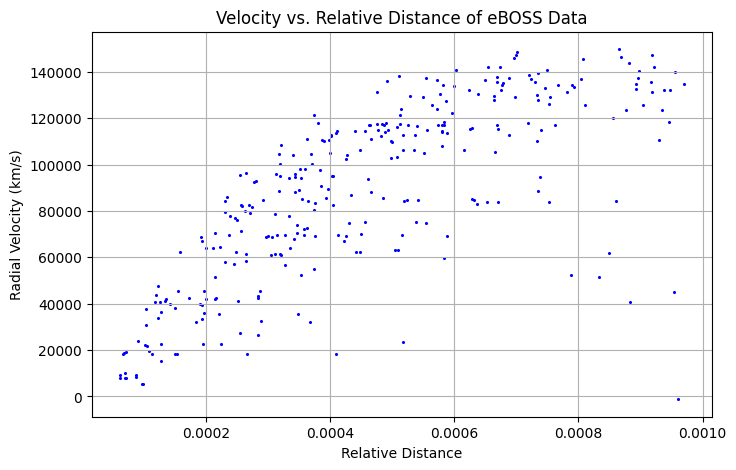

In [14]:
# Plotting eBOSS data
plt.figure(figsize=(8, 5))
plt.scatter(
    distance_velocity_array[:, 0],
    distance_velocity_array[:, 1],
    s=1.5,
    color="blue",
)
plt.title("Velocity vs. Relative Distance of eBOSS Data")
plt.xlabel("Relative Distance")
plt.ylabel("Radial Velocity (km/s)")
plt.grid(True)
plt.show()

#### Importing Abell 2199 Data
In order to obtain the actualized distances for the sample, we can use the relative distance of the first galaxy from Abell 2199 and set it equal to 1. We'll follow the same procedures as before by importing the `abell_2199.txt` file and querying eBOSS for those 32 select galaxies.

In [15]:
# Loading the Abell 2199 dataset
obs_id2 = np.loadtxt("abell_2199.txt", dtype=str)

# Querying eBOSS for the 32 Abell 2199 galaxies, sending the data to an array
results_tables2 = []
for i in obs_id2:
    query_result2 = Observations.query_criteria(
        provenance_name="eBOSS", obs_id=i
    )
    results_tables2.append(query_result2)

# Stacking the data into one table
combined_results2 = vstack(results_tables2)

# Ensuring the length of the stacked table is 32
print(f"Length of Abell 2199 dataset = {len(combined_results2)}")

Length of Abell 2199 dataset = 32


We'll gather and download the products again, and then send the FITS data to an array.

In [16]:
# Gathering and downloading full spectra files
products2 = Observations.get_product_list(combined_results2)
manifest2 = Observations.download_products(products2, mrp_only=True)

# Writing data to an array
abell_array = []
for path in manifest2["Local Path"]:
    abell_array.append(fits.open(path))

# Checking the length of the array matches the dataset
print(f"Length of Abell 2199 array = {len(abell_array)}")

INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_10729-58248-0357/spec-10729-58248-0357.fits with expected size 864000. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_10729-58248-0359/spec-10729-58248-0359.fits with expected size 864000. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_10729-58248-0657/spec-10729-58248-0657.fits with expected size 864000. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0747/spec-5190-56077-0747.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0749/spec-5190-56077-0749.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0753/spec-5190-56077-0753.fits with expected size 875520. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0756/spec-5190-56077-0756.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0757/spec-5190-56077-0757.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0758/spec-5190-56077-0758.fits with expected size 875520. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0759/spec-5190-56077-0759.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0761/spec-5190-56077-0761.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0762/spec-5190-56077-0762.fits with expected size 875520. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0790/spec-5190-56077-0790.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0793/spec-5190-56077-0793.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0795/spec-5190-56077-0795.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0797/spec-5190-56077-0797.fits with expected size 875520. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0798/spec-5190-56077-0798.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_5190-56077-0799/spec-5190-56077-0799.fits with expected size 875520. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0084/spec-6045-56072-0084.fits with expected size 1082880. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0121/spec-6045-56072-0121.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0124/spec-6045-56072-0124.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0125/spec-6045-56072-0125.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0126/spec-6045-56072-0126.fits with expected size 1082880. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0130/spec-6045-56072-0130.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0161/spec-6045-56072-0161.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0162/spec-6045-56072-0162.fits with expected size 1082880. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0163/spec-6045-56072-0163.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0164/spec-6045-56072-0164.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0165/spec-6045-56072-0165.fits with expected size 1082880. [astroquery.query]


INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0167/spec-6045-56072-0167.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0169/spec-6045-56072-0169.fits with expected size 1082880. [astroquery.query]
INFO: Found cached file ./mastDownload/SDSS/sdss_eboss_6045-56072-0206/spec-6045-56072-0206.fits with expected size 1082880. [astroquery.query]
Length of Abell 2199 array = 32


Now we can extract the redshift, error in redshift, and r-band flux values. Following the same processes as before, we can use the flux to find the relative distances.

In [17]:
# Sending redshift, error in redshift, and r-band magnitudes to arrays
z_val_abell = []
z_err_abell = []
r_flux_abell = []

for galaxy in abell_array:
    galaxy_z = galaxy[2].data["Z"]
    zerr = galaxy[2].data["Z_ERR"]
    spectroflux = galaxy[2].data["SPECTROFLUX"][:, 2]
    z_val_abell.append(galaxy_z)
    z_err_abell.append(zerr)
    r_flux_abell.append(spectroflux)

# Converting lists into arrays
z_val_abell = np.array(z_val_abell)
z_err_abell = np.array(z_err_abell)
r_flux_abell = np.array(r_flux_abell)

# Calculate relative distance
relative_distance_abell = 1 / np.sqrt(r_flux_abell)
new_relative_distance_abell = relative_distance_abell / 1e3  # kpc

# Filter out zeros
plot_array_abell = np.column_stack(
    (z_val_abell, new_relative_distance_abell, z_err_abell)
)
mask2 = ~np.isnan(plot_array_abell[:, 1])
new_array_abell = plot_array_abell[mask2]

# Calculate velocity
velocity_abell = []
velocity_err_abell = []
for i, j in zip(new_array_abell[:, 0], new_array_abell[:, 2]):
    v = c * (((1 + i) ** 2 - 1) / ((1 + i) ** 2 + 1))
    v_err = np.abs(((4 * c * (1 + i)) / ((1 + i) ** 2 + 1) ** 2)) * j
    velocity_abell.append(v)
    velocity_err_abell.append(v_err)

# Creating new array of distance, velocity, and error in velocity
distance_velocity_array_abell = np.column_stack(
    (new_array_abell[:, 1], velocity_abell, velocity_err_abell)
)

Now that we have filtered out both datasets, we can normalize the relative distances. To do this, we'll set up a ratio such that the closest galaxy in the Abell 2199 cluster equals 1:
$$
\frac{d_{1}}{d_{relative}} = \frac{1}{d_{norm}}
$$
where $d_{1}$ is the relative distance of the closest Abell 2199 galaxy, $d_{relative}$ is the array of relative distances of the eBOSS galaxies, and $d_{norm}$ is the array of normalized distances. To solve for the array of $d_{norm}$, we'll divide the array of relative distances by $d_{1}$. [[4]](https://skyserver.sdss.org/dr12/en/proj/advanced/hubble/distances.aspx)

Since we know the distance to Abell 2199 is 128 Mpc, we'll multiply the normalized distances by 128 Mpc to obtain the actualized distances. [[6]](http://ned.ipac.caltech.edu/cgi-bin/nph-objsearch?objname=Abell+2199&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES).


In [18]:
# Sorting the Abell 2199 data to find closest galaxy
sorted_abell = np.argsort(distance_velocity_array_abell[:, 0])
sorted_abell_array = distance_velocity_array_abell[sorted_abell]

# We'll take the first Abell 2199 galaxy and find the average, then set that to 1
d1_abell = sorted_abell_array[0][0]

# Normalize distances to d1_abell
norm_dist = distance_velocity_array[:, 0] / d1_abell
norm_dist_abell = distance_velocity_array_abell[:, 0] / d1_abell

# Distance to Abell 2199
distance = 128  # Mpc

Now we have normalized distances! We can multiply these by the distance to Abell 2199 and generate a plot with distances and radial velocities. We can use `scipy.optimize.curve_fit` to perform a linear fit, and in return, we can obtain the value of the slope, i.e., Hubble's constant!

In [19]:
# Defining linear fit function
def fit_func(x, m, b):
    return m * x + b

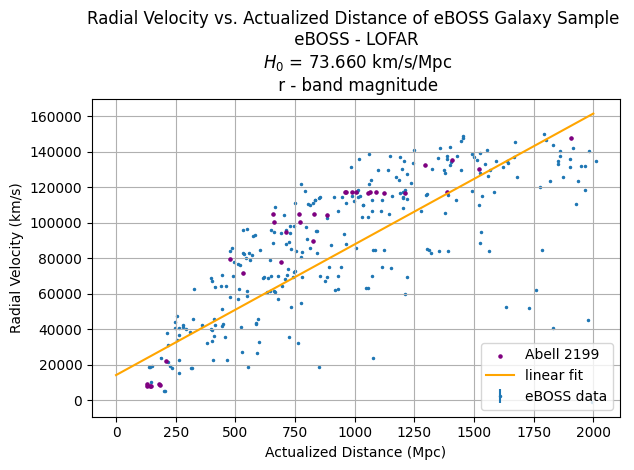

In [20]:
# Doing linear fit using scipy.optimize.curve_fit
popt, covariance = curve_fit(
    fit_func,
    norm_dist * distance,
    distance_velocity_array[:, 1],
    sigma=distance_velocity_array[:, 2],
    absolute_sigma=True,
)
m = popt[0]  # slope (Hubble's constant!)
b = popt[1]  # intercept

# Setting up an array of x-values to plot the line of best fit
x_array = np.linspace(0, 2000, 200000)

# Plotting the data as well as the line of best fit
plt.errorbar(
    norm_dist * distance,
    distance_velocity_array[:, 1],
    yerr=distance_velocity_array[:, 2],
    ms=1.5,
    fmt="o",
    label="eBOSS data",
    zorder=1,
)
plt.scatter(
    norm_dist_abell * distance,
    distance_velocity_array_abell[:, 1],
    s=5,
    label="Abell 2199",
    color="purple",
    zorder=2,
)
plt.plot(
    x_array,
    fit_func(x_array, m, b),
    label="linear fit",
    color="orange",
    zorder=3,
)
plt.ylabel("Radial Velocity (km/s)")
plt.xlabel("Actualized Distance (Mpc)")
plt.title(
    f"Radial Velocity vs. Actualized Distance of eBOSS Galaxy Sample \n eBOSS - LOFAR \n $H_{0}$ = {m:.3f} km/s/Mpc \n r - band magnitude"
)
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

### Comparing Calculated H<sub>0</sub> to Other Models 

Using data from eBOSS, we were able to calculate an H<sub>0</sub> value of $\approx$ 73.66 km/s/Mpc! 

The European Space Agency calculated an H<sub>0</sub> value of 67.40 ± 1.40 km/s/Mpc using Planck data. A recent calculation using Cepheid variables and SNe Ia from the SH0ES collaboration provided an H<sub>0</sub> value of 73.04 ± 1.04 km/s/Mpc [[3]](https://doi.org/10.3390/universe9020094). Astronomers continue to use both local distance indicators (e.g., Tip of the Red Giant Branch stars) and early-Universe probes like the CMB to constrain H<sub>0</sub>, but the Hubble Tension remains unresolved [[7]](https://www.scientificamerican.com/article/the-hubble-tension-is-becoming-a-hubble-crisis/).

Due to relativistic effects, H<sub>0</sub> values calculated from CMB observations (which probe the early Universe) tend to be lower than those calculated from nearby objects like Cepheid variables or Type Ia supernovae. Since our H<sub>0</sub> value is based on galaxy observations from eBOSS, it's reasonable that it falls on the higher end of the range, though this could also be influenced by uncertainties introduced by several assumptions:
- We assume galaxies are point sources, using a single static distance for each. 
- We calculate distances using the inverse square law, but intrinsic galaxy brightness can vary significantly. 

***
## Utilizing HST Data from MAST

The Hubble Space Telescope (HST) is a 2.4 meter serviceable telescope launched in 1990. It's equipped with three cameras (ACS, WFC3/UVIS, and WFC3/IR). Using observations from HST, we can construct an image of Abell 2199!

While we won't be covering this in the tutorial, we could use the constructed image from HST to determine the relative distance to Abell 2199 rather than using the one from NED. For example, we could use the apparent brightness of the cluster’s brightest galaxy, or analyze the relative physical sizes of its member galaxies [[4]](https://skyserver.sdss.org/dr12/en/proj/advanced/hubble/distances.aspx).

For more information about HST, check out this [overview from MAST](https://archive.stsci.edu/missions-and-data/hst)!

### Creating an Image of Abell 2199 Using HST 

To create an image of Abell 2199 using HST, we'll query MAST using `objectname = 'Abell 2199'` and specify HST using `obs_collection = 'HST'`. 

In [21]:
# Query HST using objectname
obs_hst = Observations.query_criteria(
    objectname="Abell 2199",
    # specifying Hubble data
    obs_collection="HST",
    # We want science observations and not calibration files
    intentType="science",
    # Calibrated reduced observations to display final image
    provenance_name="CAL*",
)
# Display results
obs_hst

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str3,str8,str13,str3,str6,str8,str21,str69,str9,float64,float64,str8,str21,int64,float64,float64,float64,float64,float64,str110,float64,str5,str12,int64,str1098,str34,str35,str6,bool,float64,str9,str9,str9,float64
science,HST,CALNIC,NICMOS/NIC1,HST,F160W,Infrared,ANY,UNIDENTIFIED;PARALLEL FIELD,n4t204050,247.1374494138,39.56658972864,image,"Geisler, Douglas",3,50990.52603009,50990.65356481,3583.872072,1408.3999999999999,1809.4,The Metallicity Distribution of the Globular Cluster Systems of Giant Elliptical Galaxies,51355.82724523,7265,GO,--,POLYGON -112.86104 39.564318 -112.85983199999998 39.567233 -112.85983749784737 39.567234353400465 -112.85961800000001 39.567764 -112.863384 39.568691 -112.86338579335177 39.568686672690255 -112.86407299999996 39.568856 -112.86527999999998 39.565941 -112.8652745170224 39.565939649016933 -112.86549400000001 39.56541 -112.86172799999997 39.564483 -112.8617263597632 39.564486958196 -112.86104 39.564318 -112.86104 39.564318,mast:HST/product/n4t204050_mos.jpg,mast:HST/product/n4t204050_mos.fits,PUBLIC,False,nan,24861476,109228087,109228087,86.83430001362291
science,HST,CALNIC,NICMOS/NIC3,HST,F160W,Infrared,NGC6166-WF4,GALAXY;ELLIPTICAL;BCM,n4t204070,247.1793481664,39.55485355641,image,"Geisler, Douglas",3,50990.66488426,50990.79190972,3583.872072,1408.3999999999999,1809.4,The Metallicity Distribution of the Globular Cluster Systems of Giant Elliptical Galaxies,51356.53231477,7265,GO,--,POLYGON -112.81429500000002 39.545485 -112.80873299999996 39.559266 -112.80873332280447 39.559266077458844 -112.80851899999999 39.559797 -112.82164528889807 39.56294585492904 -112.82701700000001 39.564234 -112.83257600000002 39.550452 -112.83257587496034 39.550451970020688 -112.83278999999999 39.549921 -112.83210196969837 39.54975607514 -112.83210199999996 39.549756 -112.81429500000002 39.545485 -112.81429500000002 39.545485,mast:HST/product/n4t204070_mos.jpg,mast:HST/product/n4t204070_mos.fits,PUBLIC,False,nan,24861478,109228114,109228114,73.05880201851693
science,HST,CALNIC,NICMOS/NIC3,HST,F160W,Infrared,NGC6166-WF2,GALAXY;ELLIPTICAL;BCM,n4t204010,247.1452650345,39.54149428096,image,"Geisler, Douglas",3,50990.44626157,50990.51471065,3583.872072,1408.3999999999999,1809.4,The Metallicity Distribution of the Globular Cluster Systems of Giant Elliptical Galaxies,51355.79266192,7265,GO,--,POLYGON -112.84837500000003 39.532099 -112.84816141799249 39.532629100181431 -112.848161 39.532629 -112.84298674808902 39.545469786660767 -112.84282099999996 39.545881 -112.84282101338837 39.545881003209161 -112.84260699999999 39.546412 -112.84329504962851 39.546576876865792 -112.84329500000001 39.546577 -112.86110400000001 39.550843 -112.86131754058894 39.550312889968012 -112.86131799999998 39.550313 -112.86686900000001 39.536529 -112.86618091639785 39.536364207640368 -112.86618099999998 39.536364 -112.8625780224353 39.53550125470742 -112.849063 39.532263 -112.84906268620338 39.532263778891235 -112.84837500000003 39.532099 -112.84837500000003 39.532099,mast:HST/product/n4t204010_mos.jpg,mast:HST/product/n4t204010_mos.fits,PUBLIC,False,nan,24861472,109228124,109228124,0.0
science,HST,CALNIC,NICMOS/NIC2,HST,F160W,Infrared,ABELL2199-SKYS,CALIBRATION;SKY BACKGROUND,n4hd21030,247.160006665,39.47067612935,image,"Tonry, John L.",3,50799.99439224537,50800.001336608795,383.990005,1408.3999999999999,1809.4,The SBF Hubble Diagram,51165.55783555,7453,GO,--,POLYGON -112.83682999999996 39.469599 -112.83380699999998 39.47445 -112.840036 39.476763 -112.84305900000004 39.471911 -112.83682999999996 39.469599 -112.83682999999996 39.469599 POLYGON -112.83994899999999 39.464592 -112.836926 

Similar to eBOSS, we'll retrieve and download the products for Abell 2199, specifically the fully calibrated combined images using `productGroupDescription = 'Minimum Recommended Products'` and `productSubGroupDescription = 'DRZ'`. 

In [22]:
# Get products from query
products_hst = Observations.get_product_list(obs_hst)

# Select specific products
products_hst = Observations.filter_products(
    products_hst,
    # Specify science files
    productType="SCIENCE",
    # Recommended products,
    productGroupDescription="Minimum Recommended Products",
    # DRZ files -> calibrated combined images
    productSubGroupDescription="DRZ",
)
# Display product list
products_hst

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str3,str8,str37,str67,str1,str97,str9,str28,str11,str1,str8,str20,str5,str52,int64,str9,str6,int64,str9
24801640,HST,image,ibhr01020,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/ibhr01020_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALWF3,3.7.2 (Apr-15-2024),12238,ibhr01020_drz.fits,217932480,24801640,PUBLIC,3,F475W
24801653,HST,image,ibhr13030,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/ibhr13030_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALWF3,3.7.2 (Apr-15-2024),12238,ibhr13030_drz.fits,217638720,24801653,PUBLIC,3,F814W
24801654,HST,image,ibhr13040,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/ibhr13040_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALWF3,3.7.2 (Apr-15-2024),12238,ibhr13040_drz.fits,217638720,24801654,PUBLIC,3,F814W
24834402,HST,image,jbhr01010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/jbhr01010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.9.1,12238,jbhr01010_drz.fits,215023680,24834402,PUBLIC,3,F475W
24834415,HST,image,jbhr13010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/jbhr13010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.9.1,12238,jbhr13010_drz.fits,214859520,24834415,PUBLIC,3,F814W
24834416,HST,image,jbhr13020,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/jbhr13020_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.9.1,12238,jbhr13020_drz.fits,214859520,24834416,PUBLIC,3,F814W
24834423,HST,image,jbhv02010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/jbhv02010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.9.1,12220,jbhv02010_drz.fits,23569920,24834423,PUBLIC,3,F140LP
26091389,HST,image,j6jt05010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/j6jt05011_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.9.1,9293,j6jt05011_drz.fits,214456320,26091389,PUBLIC,3,FR656N
26091432,HST,image,j6jt05020,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/j6jt05021_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.9.1,9293,j6jt05021_drz.fits,214352640,26091432,PUBLIC,3,F814W


In [23]:
# Download products into same directory
Observations.download_products(products_hst, flat=True)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str20,str8,object,object
./ibhr01020_drz.fits,COMPLETE,None,None
./ibhr13030_drz.fits,COMPLETE,None,None
./ibhr13040_drz.fits,COMPLETE,None,None
./iey929010_drz.fits,COMPLETE,None,None
./iey929020_drz.fits,COMPLETE,None,None
./j6jt05011_drz.fits,COMPLETE,None,None
./j6jt05021_drz.fits,COMPLETE,None,None
./jbhr01010_drz.fits,COMPLETE,None,None
./jbhr13010_drz.fits,COMPLETE,None,None


Each FITS file has a corresponding filter in the table above under the `filter` column. To create a color image, we'll choose three images that overlap coordinates and have different filters. 

The following images were picked based on if they overlapped in the AstroView of the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html).

In [24]:
# Opening three different filters
img1 = fits.open("j6jt05011_drz.fits")
img1_wcs = WCS(img1[1].header)

img2 = fits.open("j6jt05021_drz.fits")
img2_wcs = WCS(img2[1].header)

img3 = fits.open("iey929020_drz.fits")
img3_wcs = WCS(img3[1].header)

#### Plotting the HST Images 

We'll now set up a subplot of the three images we chose. The first two images were taken as a pair of images (hence the small whitespace in the center). You can see the overlap in all three images where there's a fairly consistent cluster of five galaxy sources. While the shapes of these galaxies aren't very clear in these images, they'll become more distinct when we create the color image!

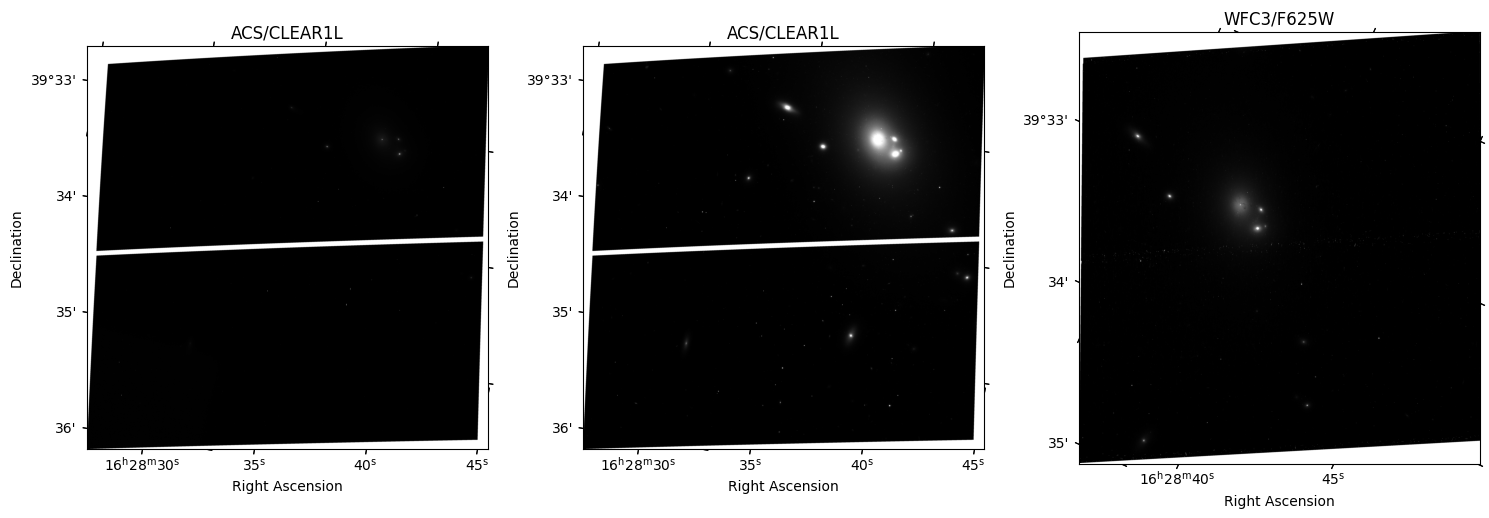

In [25]:
# Set up figure
fig = plt.figure(figsize=(15, 8))

# First image
ax1 = fig.add_subplot(1, 3, 1, projection=img1_wcs)
ax1.imshow(img1[1].data, cmap="Greys_r", vmin=0, vmax=2.5, origin="lower")
ax1.set_title(f"{img1[0].header['INSTRUME']}/{img1[0].header['FILTER1']}")
ax1.set_ylabel("Declination")
ax1.set_xlabel("Right Ascension")

# Second image
ax2 = fig.add_subplot(1, 3, 2, projection=img2_wcs)
ax2.imshow(img2[1].data, cmap="Greys_r", vmin=0, vmax=2.5, origin="lower")
ax2.set_title(f"{img2[0].header['INSTRUME']}/{img2[0].header['FILTER1']}")
ax2.set_ylabel("Declination")
ax2.set_xlabel("Right Ascension")

# Third image
ax3 = fig.add_subplot(1, 3, 3, projection=img3_wcs)
ax3.imshow(img3[1].data, cmap="Greys_r", vmin=0, vmax=2.5, origin="lower")
ax3.set_title(f"{img3[0].header['INSTRUME']}/{img3[0].header['FILTER']}")
ax3.set_ylabel("Declination")
ax3.set_xlabel("Right Ascension")

plt.tight_layout()
plt.show()

#### Colorizing the HST Image of Abell 2199 

In order to create a color image of Abell 2199, we can assign red, green, and blue to each image, then combine the three images. We must choose the image with the largest pixel dimensions, and then project the other images onto it.  

In [26]:
# Checking the shape of each image to determine which ones will be mapped onto the other
print(f"Shape of image 1: {img1[1].data.shape}")
print(f"Shape of image 2: {img2[1].data.shape}")
print(f"Shape of image 3: {img3[1].data.shape}")

Shape of image 1: (4239, 4213)
Shape of image 2: (4238, 4212)
Shape of image 3: (4446, 4130)


The third image appears to have the largest dimensions, so we'll project the first and second images onto the third using `reproject`. We'll assign the first image to red, the second to blue, and the third to green. 

In [27]:
# image 1 -> red
r, _ = reproject.reproject_interp(img1[1], img3[1].header)

# image 2 -> green
g, _ = reproject.reproject_interp(img2[1], img3[1].header)

# image 3 -> blue
b, _ = reproject.reproject_interp(img3[1], img3[1].header)

Using a ratio of red, blue, and green, we can now make a colorized image using `make_lupton_rgb`!

In [28]:
image_hst = make_lupton_rgb(r * 3.8, g * 0.2, b * 0.65, Q=4, stretch=0.75)

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/astropy/visualization/basic_rgb.py:153: RuntimeWarning: invalid value encountered in cast
  return image_rgb.astype(output_dtype)


/tmp/ipykernel_2138/2518464466.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2138/2518464466.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


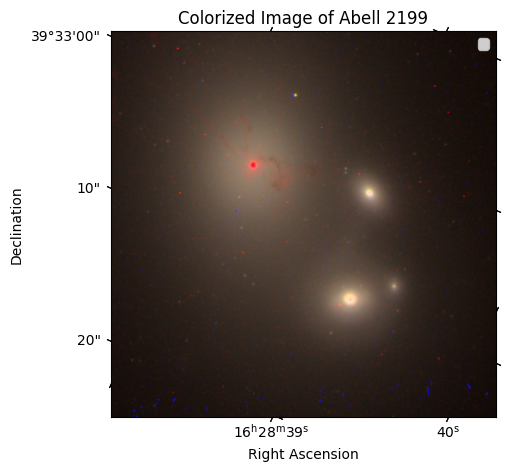

In [29]:
# Plotting the colorized image
plt.figure(figsize=(5, 5))

# Ensuring the coordinates are set to the WCS of the third image
ax = plt.subplot(projection=img3_wcs)
ax.imshow(image_hst)

# Zoom in
ax.set_xlim(1400, 2100)
ax.set_ylim(2200, 2900)

ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("Colorized Image of Abell 2199")
ax.legend()
plt.tight_layout()
plt.show()

***
## End of Tutorial 
Congratulations, you've reached the end of this notebook! You've learned how to use `astroquery.MAST` to calculate Hubble's constant from eBOSS data and make a colorized image from HST data! 

## Additional Resources 

Additional resources are linked below:

- [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss)
- [SDSS Legacy Archive at MAST User Manual](https://outerspace.stsci.edu/display/SDSS/The+SDSS+Legacy+Archive+at+MAST)
- [Original SDSS Hubble Diagram Tutorial!](https://skyserver.sdss.org/dr1/en/proj/advanced/hubble/)
- [eBOSS User Manual](https://outerspace.stsci.edu/display/SDSS/eBOSS)
- [astroquery.mast User Manual](https://astroquery.readthedocs.io/en/latest/mast/mast.html)
- [MAST API](https://mast.stsci.edu/api/v0/index.html)

## Citations 

If you use data from MAST for published research, please see the following links for information on which citations to include in your paper:

* [Citing SDSS](https://sdss.org/collaboration/citing-sdss/)
* [Citing MAST](https://archive.stsci.edu/publishing/mission-acknowledgements)
* [Citing astropy](https://www.astropy.org/acknowledging.html)

## About this Notebook

**Author(s):** Natalie Haugen (nhaugen@terpmail.umd.edu) and Julie Imig (jimig@stsci.edu)<br>
**Keyword(s):** Tutorial, eBOSS, HST, SDSS, galaxies <br>
**First published:** July 2025 <br>
**Last updated:** July 2025 <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/style-guides/master/guides/images/stsci-logo.png" alt="Space Telescope Logo" width="200px"/> 